Total number of entries in this file: 666
Print event index =  120
(The index of this event in the main script plot should be  121
Run 3825  part file  39


Text(0.5, 1.0, 'Data Waveform on side 0')

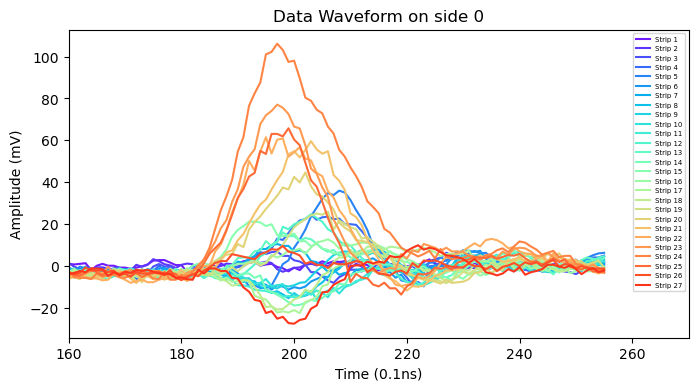

In [251]:
# extract waveform from event in the root file

import sys
sys.path.append('/Users/fengy/ANNIESofts/Analysis/ProjectionComplete/Code/')
import EventDisplay as ed
import Projection as proj
import LAPPDGeo as lg
import LoadInfo as li


import ROOT
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd


basePath = '/Users/fengy/ANNIESofts/Analysis/ProjectionComplete/'

beam_data_path = basePath + 'data/'
LAPPD_profile_path = basePath + 'LAPPDProfile/'
plot_save_path = basePath + 'plots/'

root_file_pattern = beam_data_path + 'ANNIETree_Ped2022_all.root'

file = '/Users/fengy/ANNIESofts/Analysis/ProjectionComplete/data/ANNIETree_Ped2022_all.root'

#file = '/Users/fengy/ANNIESofts/Analysis/LAPPD40_beam/paperPlot_waveform/ANNIETree_Ped2022_7mV.root'


printEntry = 120

file = ROOT.TFile(file, "READ")
tree = file.Get("Event")

print("Total number of entries in this file:", tree.GetEntries())
colors = cm.rainbow(np.linspace(0, 1, 30))

print("Print event index = ",printEntry)
print("(The index of this event in the main script plot should be ",printEntry+1)
tree.GetEntry(printEntry)



Data_Waveform = np.zeros((28, 2, 256))
for i in range(60):
    side = int(i/30)
    strip = i%30
    if strip == 0 or strip == 29:
        continue
    realStrip = strip - 1
    Data_Waveform[realStrip][side] = np.array(tree.LAPPDWaveform[i])


print("Run",tree.runNumber," part file ", tree.partFileNumber)


plt.figure(figsize=(8, 4))
waveform = [[],[]]
for i in range (1,28):
    waveform[0].append(np.array(tree.LAPPDWaveform[i]))
    plt.plot(np.array(tree.LAPPDWaveform[i]),label = "Strip "+str(i), color=colors[i])
plt.xlim(160,270)
plt.legend(loc = "upper right", fontsize = 5)
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (0.1ns)")
plt.title("Data Waveform on side 0")




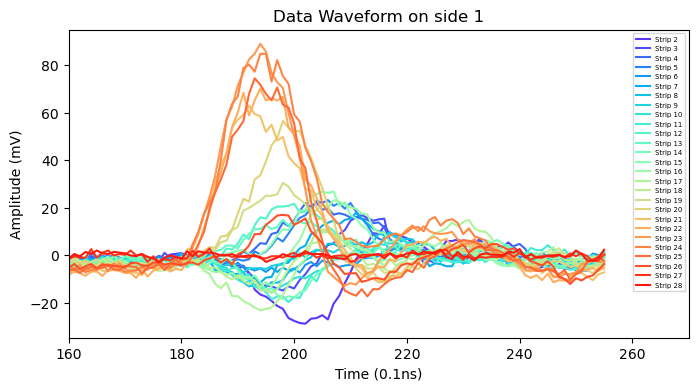

In [253]:
plt.figure(figsize=(8, 4))
for i in range (32,59):
    waveform[1].append(np.array(tree.LAPPDWaveform[i]))
    plt.plot(np.array(tree.LAPPDWaveform[i]),label = "Strip "+str(i-30), color=colors[i-30])
plt.xlim(160,270)
plt.legend(loc = "upper right", fontsize = 5)
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (0.1ns)")   
plt.title("Data Waveform on side 1")

file.Close()  

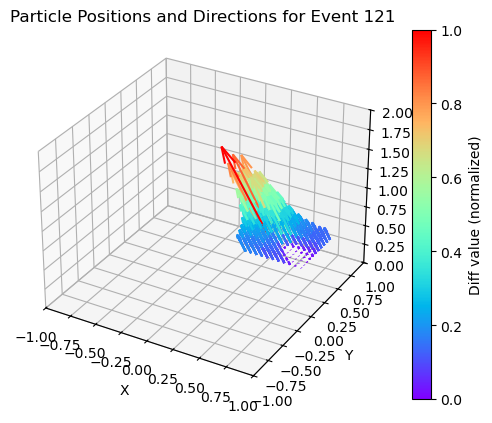

In [135]:
# 构造文件名
input_file = f'/Users/fengy/ANNIESofts/Analysis/ProjectionComplete/plots/Event{printEntry+1}output.txt'

# 读取数据
with open(input_file, 'r') as file:
    result = json.load(file)

# 提取所有的diff value，用于归一化
diff_values = [elem[6] for elem in result]  # 第7个元素是diff value
diff_values = np.array(diff_values)

# 归一化diff value
norm_diff_values = (diff_values - np.min(diff_values)) / (np.max(diff_values) - np.min(diff_values))

# 创建3D图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colorMin = 0.0

max_length = 0
mu_start_position = []
mu_start_direction = []

# 遍历每个粒子的数据
for i, elem in enumerate(result):
    # 读取粒子的x, y, z位置 (第0, 1, 2个元素)
    x, y, z = elem[0], elem[1], elem[2]
    
    # 读取粒子的x, y, z方向 (第3, 4, 5个元素)
    dir_x, dir_y, dir_z = elem[3], elem[4], elem[5]
    
    # 获取归一化的diff value（第6个元素）并计算箭头长度
    normalized_value = norm_diff_values[i]
    arrow_length = 1 - normalized_value 

    if arrow_length > max_length:
        max_length = arrow_length
        mu_start_position = [x, y, z]
        mu_start_direction = [dir_x, dir_y, dir_z]
        
    thisColorValue = 0
    if(arrow_length > colorMin):
        thisColorValue = (arrow_length - colorMin) / (1 - colorMin)
    
    # 计算颜色，使用rainbow colormap
    color = cm.rainbow(thisColorValue)
        # 绘制箭头，起点是x, y, z，方向是dir_x, dir_y, dir_z
    ax.quiver(x, y, z, dir_x, dir_y, dir_z, length=arrow_length, color=color, arrow_length_ratio=0.2)

# 设置颜色条
norm = plt.Normalize(vmin=colorMin, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cm.rainbow, norm=norm)
sm.set_array([])

# 设置颜色条
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Diff value (normalized)')

# 设置图像标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Particle Positions and Directions for Event {printEntry+1}')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([0, 2])

# 显示图像
plt.show()

In [115]:
print("Got mu_start_position:", mu_start_position)
print("Got mu_start_direction:", mu_start_direction)

Got mu_start_position: [0.7277094303703991, -0.30599593603673947, 1.2]
Got mu_start_direction: [-0.4142965873952119, -0.0158846206642928, 0.9100033057626952]


In [117]:

muon_prop_steps = 300
muon_step = 0.01
mu_positions = [mu_start_position + (i * np.array(mu_start_direction) * muon_step) for i in range(muon_prop_steps)]
# select the muon step only if the xyz position is within the tank
mu_positions = [pos for pos in mu_positions if (pos[2] < 3)]




LAPPD_Centers = [[0,-0.2255,2.951]] # center of LAPPD 40
LAPPD_Directions = [[0,0,-1], [1,0,-1], [-1,0,-1]]
LAPPD_stripWidth = 0.462
LAPPD_stripSpace = 0.229
LAPPD_gridSize = LAPPD_stripWidth + LAPPD_stripSpace
LAPPD_grids = []
for i in range (len(LAPPD_Centers)):
    LAPPD_grids.append(lg.LAPPD_Grid_position(np.array(LAPPD_Centers[i]), np.array(LAPPD_Directions[i])))


absorption_file = LAPPD_profile_path + 'interpolated_water_absorption_data.csv'
absorption_data = pd.read_csv(absorption_file)
absorption_wavelengths = absorption_data['Wavelength (nm)'].values
absorption_coefficients = absorption_data['Absorption Coefficient'].values

# Load QE data for LAPPD 25 and LAPPD 63
qe_file_25 = LAPPD_profile_path + 'LAPPD25_interpolated_photon_energy_qe.csv'
qe_file_63 = LAPPD_profile_path + 'LAPPD63_interpolated_photon_energy_qe.csv'

qe_data_25 = pd.read_csv(qe_file_25)
qe_data_63 = pd.read_csv(qe_file_63)

wavelength25 = qe_data_25['Wavelength (nm)'].values
QE25 = qe_data_25['Average QE'].values

wavelength63 = qe_data_63['Wavelength (nm)'].values
QE63 = qe_data_63['Average QE'].values

# Create arrays for QE vs Wavelength for 3 LAPPDs
QEvsWavelength_lambda = [wavelength25, wavelength63, wavelength63]
QEvsWavelength_QE = [QE25, QE63, QE63]

qe_file = LAPPD_profile_path + 'interpolated_QE_2d_Position.csv'
gain_file = LAPPD_profile_path + 'interpolated_gain_2d.csv'

qe_2d, gain_2d = li.load_qe_gain_distribution(qe_file, gain_file)

sPE_pulse_time, sPE_pulse = li.read_spe_pulse_from_root(LAPPD_profile_path + "singlePETemplate_LAPPD40.root", "pos10_1_1D", 7)




In [119]:
HitResults = proj.parallel_process_positions(mu_positions, mu_start_direction, LAPPD_grids)
Results_withMuTime = proj.process_results_with_mu_time(HitResults, muon_step)
updated_hits_withPE = proj.update_lappd_hit_matrices(
    results_with_time=Results_withMuTime,       
    absorption_wavelengths = absorption_wavelengths,
    absorption_coefficients = absorption_coefficients,
    qe_2d=qe_2d,                               # QE 2D, normalized
    gain_2d=gain_2d,                           # gain distribution 2D, normlized
    QEvsWavelength_lambda=QEvsWavelength_lambda,    # QE vs wavelength, wavelength array
    QEvsWavelength_QE=QEvsWavelength_QE,            # QE vs wavelength, QE array
    bin_size=10,                                    # wavelength bin size
    CapillaryOpenRatio = 0.64                       # capillary open ratio of MCP
)

totalPE = 0

LAPPD_Hit_2D = []
for i in range (1):
    LAPPD_Hit_2D.append([])
    for j in range(28):
        LAPPD_Hit_2D[i].append([])

for i in range (len(updated_hits_withPE)):
    # each particle step
    for j in range(len(updated_hits_withPE[i])):
        # just loop all hits

        # for each strip, i.e. same x position but different y position
        # each second index is a strip, loop the first index to get all positions on that strip
        LAPPD_Hit_2D[updated_hits_withPE[i][j][0]][updated_hits_withPE[i][j][2]].append((updated_hits_withPE[i][j][1], updated_hits_withPE[i][j][3], updated_hits_withPE[i][j][5]))
        totalPE+=updated_hits_withPE[i][j][5]

print("Total PE: ", totalPE)

Sim_Waveforms = proj.generate_lappd_waveforms(LAPPD_Hit_2D, sPE_pulse_time, sPE_pulse, LAPPD_stripWidth, LAPPD_stripSpace)
#Sim_Waveforms[LAPPD_id][0=dowm, 1=up][256]

shiftDT, min_diff, waveform_diff, Sim_Waveform_shifted = proj.align_waveforms(Sim_Waveforms[0], Data_Waveform)



Total PE:  322.56796853766144


Text(0.5, 1.0, 'Simulated Waveform on side 0')

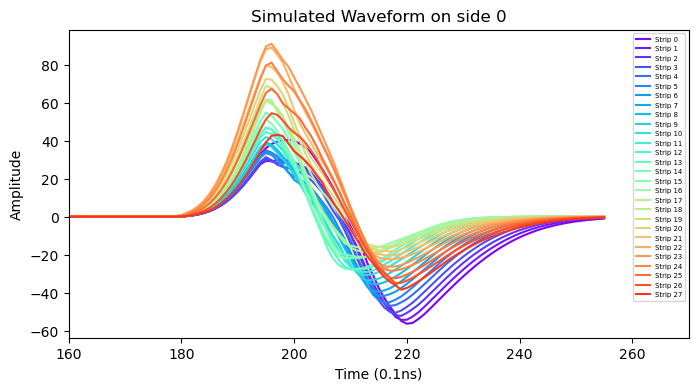

In [175]:
plt.figure(figsize=(8, 4))
for i in range (len(Sim_Waveform_shifted)):
    plt.plot(Sim_Waveform_shifted[i][0],label = "Strip "+str(i), color=colors[i])
plt.xlim(160,270)
plt.legend(loc = "upper right", fontsize = 5)
plt.ylabel("Amplitude")
plt.xlabel("Time (0.1ns)")
plt.title("Simulated Waveform on side 0")




Text(0.5, 1.0, 'Simulated Waveform on side 1')

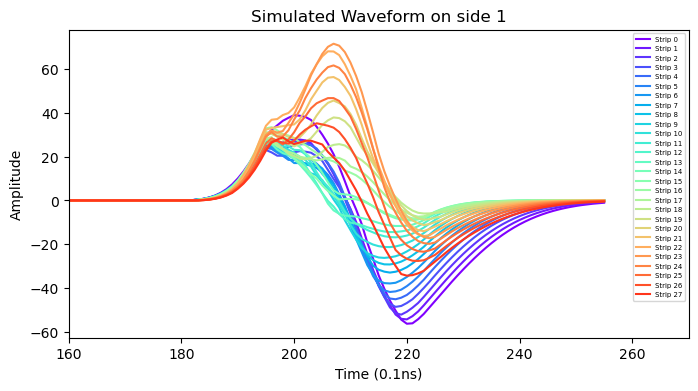

In [177]:
plt.figure(figsize=(8, 4))
for i in range (len(Sim_Waveform_shifted)):
    plt.plot(Sim_Waveform_shifted[i][1],label = "Strip "+str(i), color=colors[i])
plt.xlim(160,270)
plt.legend(loc = "upper right", fontsize = 5)
plt.ylabel("Amplitude")
plt.xlabel("Time (0.1ns)")
plt.title("Simulated Waveform on side 1")

Text(0.5, 1.0, 'Simulated Waveform on side 1')

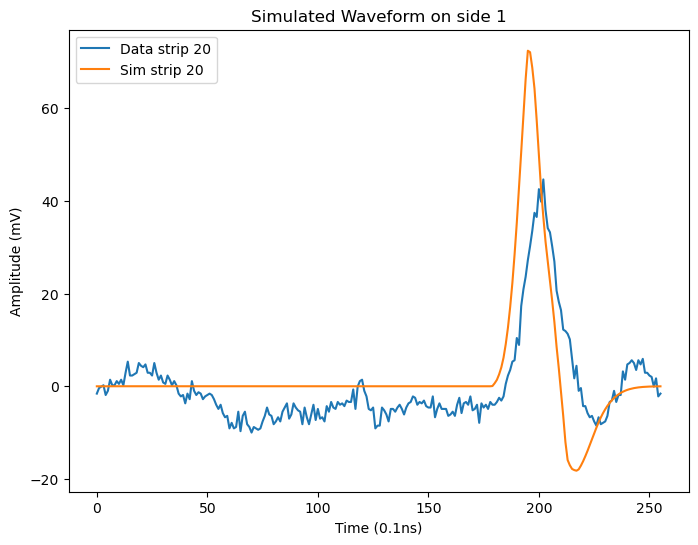

In [193]:
printStrip = 20

plt.figure(figsize=(8, 6))
           
plt.plot(waveform[0][printStrip], label = "Data strip "+str(printStrip))
plt.plot(Sim_Waveform_shifted[printStrip][0], label = "Sim strip "+str(printStrip))

#plt.xlim(100,270)
plt.legend(loc = "upper left")
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (0.1ns)")
plt.title("Simulated Waveform on side 1")


Text(0.5, 1.0, 'Data and Simulated Waveform on side 1 strip 20')

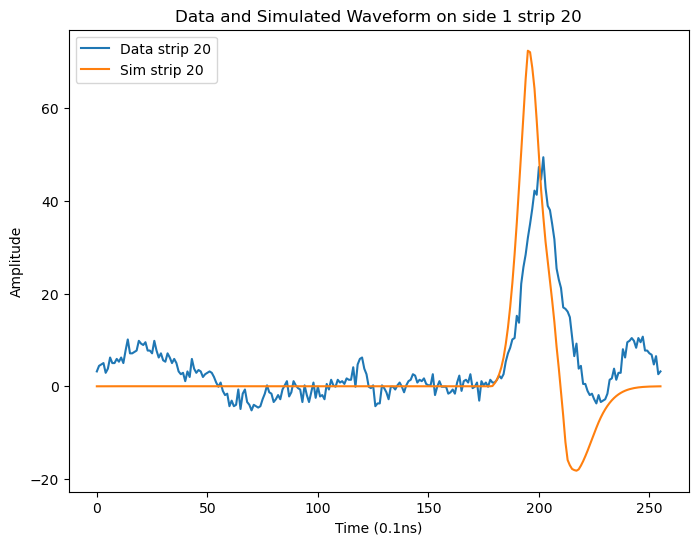

In [195]:
updatedWavefrom = waveform[0][printStrip]

bsStart = 80
bsEnd = 150
bs = sum([waveform[0][printStrip][i] for i in range(bsStart,bsEnd)]) / (bsEnd - bsStart)

updatedWavefrom = [i-bs for i in updatedWavefrom]

plt.figure(figsize=(8, 6))
           
plt.plot(updatedWavefrom, label = "Data strip "+str(printStrip))
plt.plot(Sim_Waveform_shifted[printStrip][0], label = "Sim strip "+str(printStrip))

#plt.xlim(100,270)
plt.legend(loc = "upper left")
plt.ylabel("Amplitude")
plt.xlabel("Time (0.1ns)")
plt.title("Data and Simulated Waveform on side 1 strip "+str(printStrip))


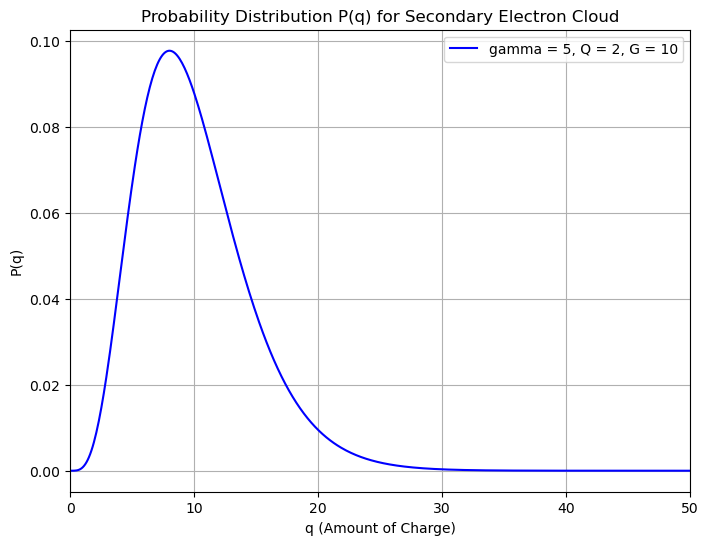

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

# Function for P(q) based on the formula
def P_q(q, gamma_val, Q):
    return (1 / (gamma(gamma_val) * Q**gamma_val)) * (q**(gamma_val - 1)) * np.exp(-q / Q)

# Test values for gamma and Q
gamma_val = 5  # shape parameter
Q = 2  # scale parameter

# Generate q values
q_values = np.linspace(0, 50, 500)

# Calculate P(q)
P_values = P_q(q_values, gamma_val, Q)
G = gamma_val*Q

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(q_values, P_values, label=f'gamma = {gamma_val}, Q = {Q}, G = {G}', color='b')
plt.title('Probability Distribution P(q) for Secondary Electron Cloud')
plt.xlabel('q (Amount of Charge)')
plt.ylabel('P(q)')
plt.grid(True)
plt.legend()


# Show gamma and Q values on the plot
#plt.text(12, 0.03, f'$\gamma$ = {gamma_val}\nQ = {Q}', bbox=dict(facecolor='white', alpha=0.5))
plt.xlim(0,50)
# Display the plot
plt.show()


In [257]:
0.7**2/(468.75*1e-8)

104533.33333333331